##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
%pip install ipykernel
%pip install pandas 
%pip install numpy
%pip install pyarrow
%pip install fastparquet
%pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
%pip install xgboost

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [13]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file
filepath = "./data/catB_train.parquet" 

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

## Data Cleaning and Preprocessing

### Reading Data

In [ ]:
df = pd.read_parquet(filepath)
df.head()

### Shape of Dataset

### EDA

In [3]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 17992
Number of columns: 304


Text(0.5, 1.0, 'Distribution of target column')

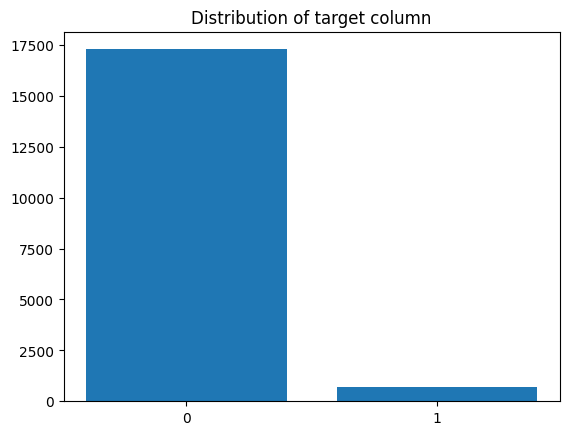

In [16]:
#check if dataset is imbalanced
plt.bar(x = ('0','1'),
        height = ((df['f_purchase_lh'].isna()).sum(),(df['f_purchase_lh']==1).sum()))
plt.title('Distribution of target column')


### Drop Columns with Only One Unique Value

In [17]:
def drop_cols_with_one_value(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop columns from a DataFrame that contain only a single unique value.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with columns containing only a single unique value removed.
    """
    # Identify columns with a single unique value
    single_value_columns = [col for col in df.columns if df[col].nunique(dropna=False) == 1]
    columns_to_drop = set(single_value_columns)
    
    # Drop identified columns
    df = df.drop(columns=columns_to_drop)

    return df

df = drop_cols_with_one_value(df)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 17992
Number of columns: 247


### Handling NaN Values in Coluns

In [ ]:
def handle_na(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values in a DataFrame through a series of data imputation and preprocessing steps.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with missing values handled.
    """
    # Convert target col to 0 or 1
    df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)

    # Dropping columns where na values take up 80% of the column
    df_temp = df.dropna(thresh = df.shape[0]*0.2, axis = 1).copy()

    # Drop clntnum column
    df_temp = df_temp.drop('clntnum', axis=1)
    
    # Try casting categorical columns to numeric to reduce encoding
    non_numeric_cols = df_temp.select_dtypes(include=["object"]).columns
    for i in range(len(non_numeric_cols)):
        try:
            df_temp[non_numeric_cols[i]] = pd.to_numeric(df_temp[non_numeric_cols[i]])
        except ValueError:
            continue
    non_numeric_cols = df_temp.select_dtypes(include=["object"]).columns

    # Extract year from columns containing dates
    df_temp['cltdob_fix'] = df_temp['cltdob_fix'].str[:4]
    df_temp['min_occ_date'] = df_temp['min_occ_date'].str[:4]

    # Fill NA values for categorical columns with 'Missing'
    df_temp[non_numeric_cols] = df_temp[non_numeric_cols].fillna('Missing')

    # Fill NA values for numerical columns with mean. For binary columns, mode is used
    numeric_cols_with_na = df_temp.select_dtypes(include=["int64", "float64"]).columns[df_temp.select_dtypes(include=["int64", "float64"]).isna().any()].tolist()
    
    for i in numeric_cols_with_na:
        if len(df_temp[i].unique()) <= 3:
            df_temp[i] = df_temp[i].fillna(df_temp[i].mode()[0])
        else:
            df_temp[i] = df_temp[i].fillna(df_temp[i].mean())

    return df_temp

test_df = handle_na(df)
test_df.head()

### Encoding Dataframe

In [ ]:
def encoder(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encodes strings found in a dataframe into numbers using sklearn's LabelEncoder

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with numerical values.
    """        
    # race and ctrycode is manually encoded into binary
    test_df['race_desc'] = np.where(test_df['race_desc'] == 'Chinese', 1, 0)
    test_df['ctrycode_desc'] = np.where(test_df['ctrycode_desc'] == 'Singapore', 1, 0)

    # Dataframe manipulation via LabelEncoder
    for column in df.columns:
        # if column is already in numbers or column is 'clntnum', skip the column
        if df[column].dtype == np.number:
            continue
        
        else:
            df[column] = LabelEncoder().fit_transform(df[column])

    return df

encoded_df = encoder(test_df)
encoded_df.head()

### Train-Test Split and Resampling Training Dataset

In [34]:
def train_test_resample(df: pd.DataFrame) -> tuple:
    """
    Splits a dataframe into training and test sets, and oversamples the training set via SMOTE.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - (x_train_resampled, x_test, y_train_resampled, y_test) (tuple of np.ndarray): 4 arrays attained after splitting the dataset into training and test sets.
    """      

    # split into x and y dataframes
    x = df.drop(['f_purchase_lh'], axis=1)
    y = df['f_purchase_lh']

    # MinMax normalization of values in x
    min_max_scaler = MinMaxScaler()
    x = min_max_scaler.fit_transform(x)

    # split dataset into train and test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # rebalance dataset using smote
    sm = SMOTE(random_state=1, k_neighbors=20)
    x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

    return x_train_resampled, x_test, y_train_resampled, y_test

x_train_resampled, x_test, y_train_resampled, y_test = train_test_resample(encoded_df)


## Modelling

### XGBoost Model

In [35]:
def prediction(x_train_resampled, x_test, y_train_resampled, y_test) -> tuple:
      """
      Predicts whether a customer will purchase a policy in the next 3 months.

      Parameters:
      - x_train_resampled (np.ndarray): Resampled training set for features
      - x_test (np.ndarray): Test set for features
      - y_train_resampled (np.ndarray): Resampled training set for target column
      - y_test (np.ndarray): Test set for target column

      Returns:
      - (y_pred, class_report, con_matrix) (tuple): 
        1) y_pred is the prediction of target column (either 0 or 1)
        2) class_report contains the various scores (accuracy, f1-score etc) of the model
        3) con_matrix contains the TP, TN, FP, FN values
      """     

      # xgboost model
      xgb_model = XGBClassifier(
            learning_rate = 0.01,
            subsample = 0.1,
            colsample_bytree = 0.1,
            max_depth = 8,
      )

      xgb_model.fit(x_train_resampled, y_train_resampled)
      y_pred = xgb_model.predict(x_test)
      class_report = classification_report(y_test, y_pred)
      con_matrix = confusion_matrix(y_test, y_pred)

      return y_pred, class_report, con_matrix

y_pred, class_report, con_matrix = prediction(x_train_resampled, x_test, y_train_resampled, y_test)
print(y_pred)
print(class_report)
print(con_matrix)

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3457
         1.0       0.28      0.31      0.30       142

    accuracy                           0.94      3599
   macro avg       0.63      0.64      0.63      3599
weighted avg       0.94      0.94      0.94      3599

[[3346  111]
 [  98   44]]


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [36]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

    The function accepts a dataframe as input and return an iterable (list)
    of binary classes as output.

    The function should be coded to test on hidden data
    and should include any preprocessing functions needed for your model to perform. 
        
    All relevant code MUST be included in this function.
    '''
    result = []

    # specify train file path
    train_filepath = "./data/catB_train.parquet" 
    train_df = pd.read_parquet(train_filepath) #.iloc[5000:]
    test_count = hidden_data.shape[0]

    # drop all unwanted columns
    merged_df = pd.concat([hidden_data, train_df])
    dropped_df = drop_cols_with_one_value(merged_df)
    
    # clean up dropped_df
    cleaned_df = handle_na(dropped_df)

    # encode cleaned_df
    encoded_df = encoder(cleaned_df)

    # train test split 
    test_set = encoded_df.iloc[:test_count]
    train_set = encoded_df.iloc[test_count:]
    
    x_train = train_set.drop(['f_purchase_lh'], axis=1)
    y_train = train_set['f_purchase_lh']
    x_test = test_set.drop(['f_purchase_lh'], axis=1)
    y_test = test_set['f_purchase_lh']

    # rebalance dataset using smote
    sm = SMOTE(random_state=1, k_neighbors=20)
    x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

    # generate the predictions
    result, class_report, con_matrix = prediction(x_train_resampled, x_test, y_train_resampled, y_test)
    
    return result, class_report, con_matrix

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_filepath = "./data/catB_test.parquet" # change this file path to the actual test filepath
test_df = pd.read_parquet(test_filepath) #.iloc[:5000]

# run the test 
result, class_report, con_matrix = testing_hidden_data(test_df)
print(result)
print(class_report)
print(con_matrix)

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!